In [39]:
import numpy as np
import cv2
import os
import imageio.v3 as iio
import matplotlib.pyplot as plt
from skimage.feature import hog, local_binary_pattern
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import pairwise_distances

In [40]:
# --- Tiền xử lý ảnh ---
def preprocess_image(img, img_size=(100, 100)):
    if img.dtype == np.uint8 and img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if img.ndim != 2:
        raise ValueError("Ảnh không phải 2D sau khi xử lý.")
    # Sử dụng CLAHE thay cho EqualizeHist
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
    img = cv2.resize(img, img_size)
    img = img.astype(np.float32) / 255.0
    return img

Assignment 2 (4 điểm)
Đọc dữ liệu ảnh training

In [41]:
# --- Trích xuất đặc trưng HOG ---
def extract_hog(imgs, img_size=(100, 100)):
    features = []
    for img in imgs:
        img = img.reshape(img_size)
        feature = hog(
            img, orientations=9, pixels_per_cell=(8, 8),
            cells_per_block=(3, 3), block_norm='L2-Hys',
            transform_sqrt=True
        )
        features.append(feature)
    return np.array(features)



In [42]:
# --- Trích xuất đặc trưng LBP ---
def extract_lbp(imgs, img_size=(100, 100), P=8, R=1):
    features = []
    for img in imgs:
        img = img.reshape(img_size)
        img_uint8 = (img * 255).clip(0, 255).astype(np.uint8)
        lbp = local_binary_pattern(img_uint8, P, R, method='uniform')
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
        hist = hist.astype(float)
        hist /= (hist.sum() + 1e-6)
        features.append(hist)
    return np.array(features)



In [43]:
# --- Load ảnh train ---
def load_images_from_folder(folder_path, img_size=(100, 100)):
    images, labels = [], []
    for person_name in os.listdir(folder_path):
        person_path = os.path.join(folder_path, person_name)
        if os.path.isdir(person_path) and person_name != 'test':
            for filename in os.listdir(person_path):
                img_path = os.path.join(person_path, filename)
                try:
                    img = iio.imread(img_path, index=0)
                    img = preprocess_image(img, img_size)
                    images.append(img.flatten())
                    labels.append(person_name)
                except Exception as e:
                    print(f"Lỗi khi đọc ảnh: {img_path} - {e}")
    return np.array(images), np.array(labels)

In [44]:
# --- Load ảnh test ---
def load_test_images(folder_path, img_size=(100, 100)):
    images, labels, filenames = [], [], []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        try:
            img = iio.imread(img_path, index=0)
            img = preprocess_image(img, img_size)
            images.append(img.flatten())
            label = filename.split('.')[0]
            labels.append(label)
            filenames.append(filename)
        except Exception as e:
            print(f"Lỗi khi đọc ảnh test: {img_path} - {e}")
    return np.array(images), np.array(labels), filenames



In [45]:
# --- Chuẩn hóa dữ liệu ---
def standardize(X):
    return ((X - np.mean(X, axis=0)) / (np.std(X, axis=0) + 1e-6)).astype(np.float32)



In [46]:
# --- Phân loại bằng cosine distance ---
def classify(X_test, X_train, y_train):
    distances = pairwise_distances(X_test, X_train, metric='euclidean')
    preds_idx = np.argmin(distances, axis=1)
    return y_train[preds_idx]




PCA với 20 chiều

In [47]:
# --- PCA bằng numpy ---
def pca_numpy(X, n_components):
    print("Đang thực hiện PCA...")
    mean_vector = X.mean(axis=0)
    X_centered = X - mean_vector
    cov_matrix = np.cov(X_centered, rowvar=False)
    eig_vals, eig_vecs = np.linalg.eigh(cov_matrix)
    sorted_indices = np.argsort(eig_vals)[::-1]
    top_vectors = eig_vecs[:, sorted_indices[:n_components]]
    X_reduced = np.dot(X_centered, top_vectors)
    return X_reduced, top_vectors, mean_vector

Assignment 3 

 Visualize eigenfaces (cơ sở không gian chính)

In [48]:
# --- Hiển thị eigenfaces dưới dạng ảnh ---
def plot_eigenfaces(eigenvectors, n_components=20, img_shape=(100, 100)):
    plt.figure(figsize=(15, 6))
    for i in range(n_components):
        plt.subplot(2, 10, i + 1)
        eigenface = eigenvectors[:, i].reshape(img_shape)
        plt.imshow(eigenface, cmap='gray')
        plt.title(f"Eigenface {i + 1}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Dự đoán và tính độ chính xác

Đang trích xuất đặc trưng cho tập train...
Đang trích xuất đặc trưng cho tập test...
Đang thực hiện PCA...
Đang thực hiện PCA...


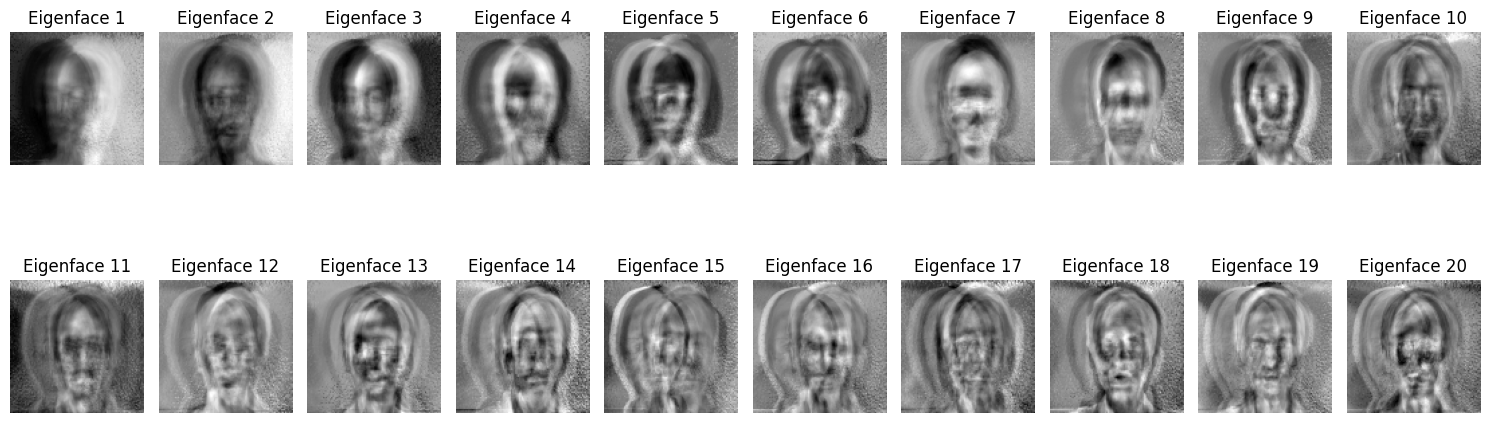

Độ chính xác nhận diện khuôn mặt: 86.67%


In [49]:
if __name__ == "__main__":
    base_path = 'C:/Users/ADMIN/Downloads/yalefaces/yalefaces'
    train_path = base_path
    test_path = os.path.join(base_path, 'test')

    # --- Load dữ liệu ---
    X_train_raw, y_train = load_images_from_folder(train_path)
    X_test_raw, y_test, test_filenames = load_test_images(test_path)

    # --- Trích xuất đặc trưng HOG + LBP ---
    print("Đang trích xuất đặc trưng cho tập train...")
    X_train_hog = extract_hog(X_train_raw)
    X_train_lbp = extract_lbp(X_train_raw)
    X_train_features = np.hstack((X_train_hog, X_train_lbp))

    print("Đang trích xuất đặc trưng cho tập test...")
    X_test_hog = extract_hog(X_test_raw)
    X_test_lbp = extract_lbp(X_test_raw)
    X_test_features = np.hstack((X_test_hog, X_test_lbp))

    # --- Chuẩn hóa ---
    X_train_std = standardize(X_train_features)
    X_test_std = standardize(X_test_features)

    # --- PCA để phân loại ---
    X_train_pca, eigenvectors, mean_vector = pca_numpy(X_train_std, n_components=20)
    X_test_centered = X_test_std - mean_vector
    X_test_pca = np.dot(X_test_centered, eigenvectors)

    # --- PCA trên ảnh gốc để hiển thị eigenfaces ---
    X_train_img_std = standardize(X_train_raw)
    _, eigenvectors_img, _ = pca_numpy(X_train_img_std, n_components=20)
    plot_eigenfaces(eigenvectors_img, n_components=20, img_shape=(100, 100))

    # --- Phân loại ---
    predictions = classify(X_test_pca, X_train_pca, y_train)

    # --- Accuracy ---
    accuracy = np.mean(predictions == y_test)
    print(f"Độ chính xác nhận diện khuôn mặt: {accuracy * 100:.2f}%")

In [50]:
  # --- Accuracy ---
accuracy = np.mean(predictions == y_test)
print(f"Độ chính xác nhận diện khuôn mặt: {accuracy * 100:.2f}%")

Độ chính xác nhận diện khuôn mặt: 86.67%
